Convolutional Neural Network project


Project video : https://www.youtube.com/watch?v=nVhau51w6dM&list=PLNM6wnKDjvEMM6ugvm1xxsn4VrLNN1Xj3&index=4

project codes : https://colab.research.google.com/drive/1G_ixTTBy6tVm4R7B7qYEdokjilLBdLdq?usp=sharing

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

In [31]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

In [32]:
train_ds, valid_ds=ds["train"], ds["validation"]

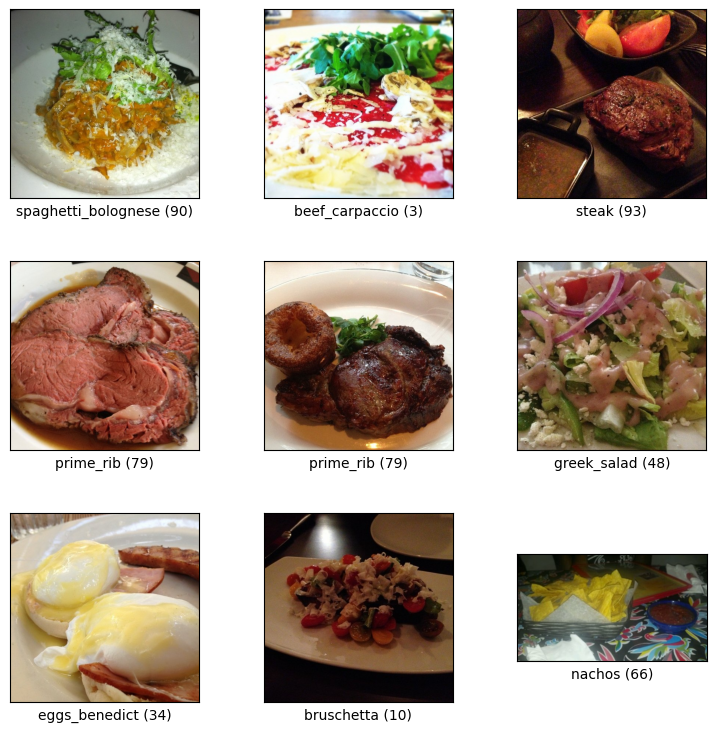

In [33]:
fig=tfds.show_examples(train_ds, ds_info)

In [34]:
MAX_SIDE_LEN=128 #shape making
HOT_DOG_CLASS=55  #class
train_ds=train_ds.map(
    lambda image, label:(tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label==HOT_DOG_CLASS, dtype=tf.int32))

)
valid_ds=valid_ds.map(
    lambda image, label:(tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN ]), dtype=tf.int32), tf.cast(label==HOT_DOG_CLASS, dtype=tf.int32))
)

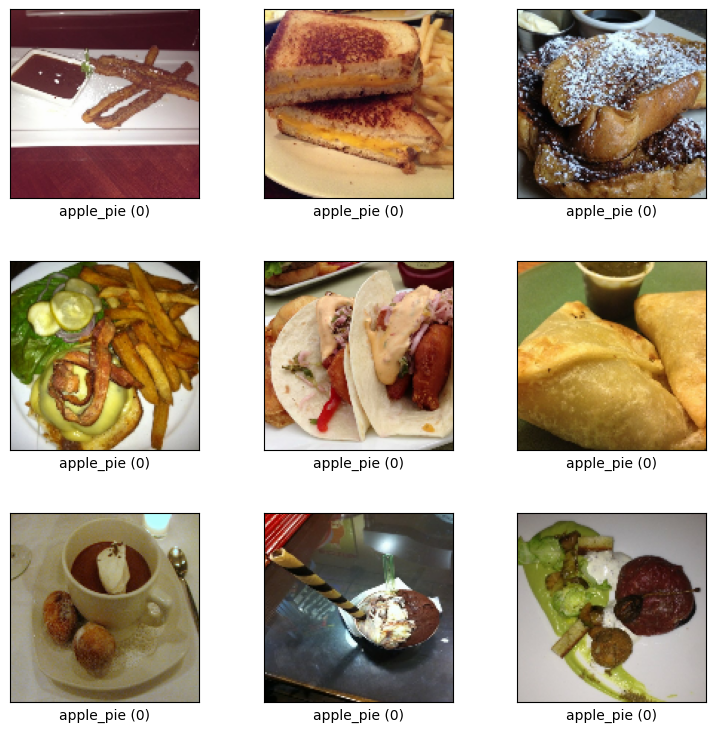

In [35]:
fig=tfds.show_examples(train_ds, ds_info)

1- hotdogs
2-not hotdogs

In [36]:
train_hd_size, valid_hd_size=750,250
train_hotdogs=train_ds.filter(lambda image, label: label==1).repeat(3)
train_nothotdogs=train_ds.filter(lambda image, label:label==0)

In [37]:
valid_hotdogs=valid_ds.filter(lambda image, label: label==1).repeat(3)
valid_nothotdogs=valid_ds.filter(lambda image, label:label==0)

In [38]:
batch_size=16
#making new train set (50%-50%)
train_ds=tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                              [0.5,0.5],
                                              stop_on_empty_dataset=True)
train_ds=train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds=tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                              [0.5,0.5],
                                              stop_on_empty_dataset=True)
valid_ds=valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [39]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[ 72 115 150]
   [ 96 129 154]
   [152 184 205]
   ...
   [251 254 223]
   [251 254 223]
   [250 253 222]]

  [[116 157 188]
   [ 76 113 140]
   [125 163 189]
   ...
   [251 254 223]
   [251 254 223]
   [250 253 222]]

  [[143 182 210]
   [ 96 138 167]
   [ 66 106 133]
   ...
   [251 255 222]
   [250 254 221]
   [252 255 223]]

  ...

  [[ 89  89  81]
   [ 91  91  83]
   [ 94  94  86]
   ...
   [ 55  64  69]
   [ 36  44  52]
   [ 31  39  48]]

  [[ 88  93  82]
   [ 93  95  85]
   [ 92  93  84]
   ...
   [ 55  64  71]
   [ 43  52  60]
   [ 33  42  50]]

  [[ 88  96  83]
   [ 93  98  86]
   [ 98  99  89]
   ...
   [ 53  59  65]
   [ 43  49  54]
   [ 36  42  47]]]


 [[[ 16   2   1]
   [ 25  10   7]
   [ 28  10   7]
   ...
   [  1   3   0]
   [  6   6   3]
   [  5   6   1]]

  [[ 16   5   2]
   [ 18   7   3]
   [ 19   7   2]
   ...
   [  0   2   0]
   [  4   5   1]
   [  5   6   1]]

  [[ 23   7   6]
   [ 20   5   2]
   [ 19   4   0]
   ...
   [  0   1   0]
   [  3   4   0]


#Neural Network Implementation

> Indented block



In [40]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)
])

In [48]:
for i,_ in ds["train"].take(1):
  image=i

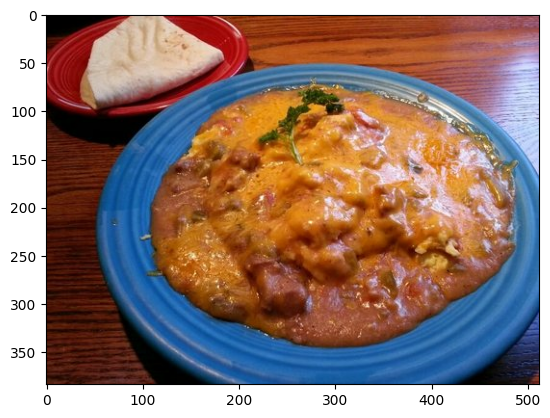

In [49]:
plt.imshow(image)

In [50]:
image=tf.cast(tf.expand_dims(image,0), tf.float32)
image/=255.0

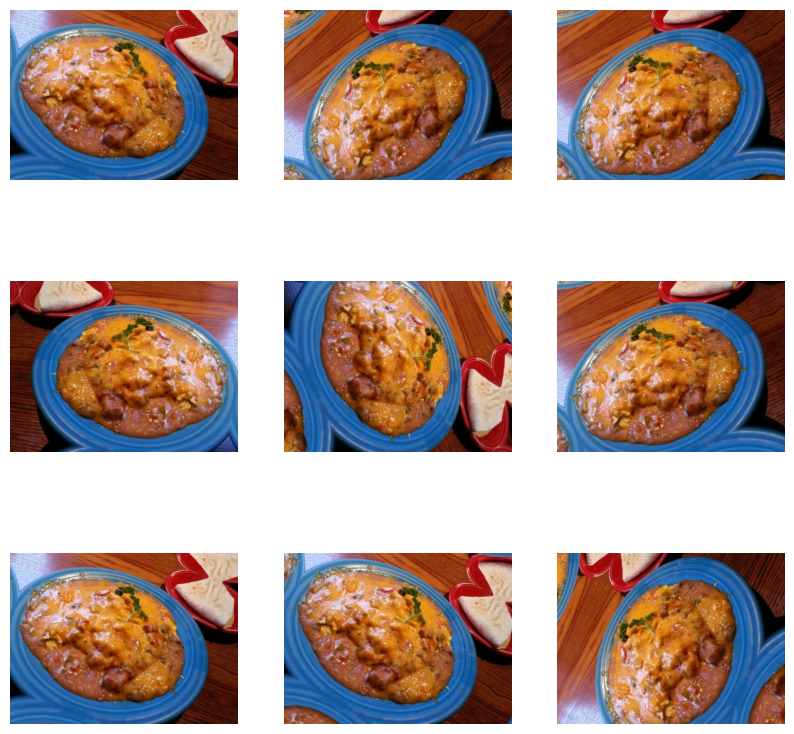

In [52]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image=data_augmentation(image)
  ax=plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [54]:
random.seed(0)
model=models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(128,(3,3), activation="relu", input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64,(3,3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [55]:
lr=0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [57]:
epochs=3
history=model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/3
280/280 [==============================] - 474s 2s/step - loss: 0.7825 - accuracy: 0.5475 - val_loss: 0.7542 - val_accuracy: 0.5193
Epoch 2/3
280/280 [==============================] - 463s 2s/step - loss: 0.7426 - accuracy: 0.5482 - val_loss: 0.7203 - val_accuracy: 0.5647
Epoch 3/3
280/280 [==============================] - 459s 2s/step - loss: 0.7205 - accuracy: 0.5540 - val_loss: 0.7023 - val_accuracy: 0.5816


In [58]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in valid_ds.take(1):
  images=image_batch
  labels=label_batch

<Figure size 1000x1000 with 0 Axes>

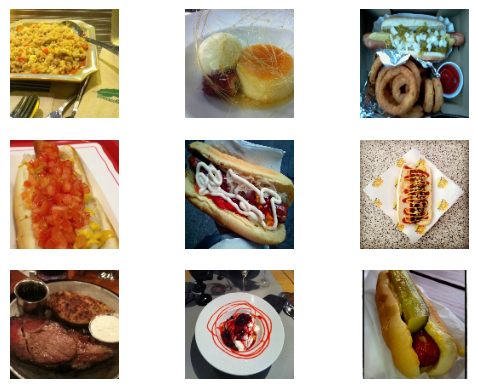

In [59]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [60]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 0, 1, 1, 1, 1, 0, 0, 1], dtype=int32)>